In [1]:
import numpy as np
import matplotlib.pyplot as plt

from src.optimization_models import wind_investment

In [2]:
### Costs
# generation costs
c = 2

# investment cost [per unit of capacity]
cinv = 3

# wind spillage and load shedding costs
cws = 6.5
cls = 10

### Line and Generators characteristics 
# reactance
x = np.array([0.1, 0.1, 0.1], dtype=float)

# capacity
Pmax = 20.0

### Scenarios of demand and wind
scenarios = np.array([
    [0.570155221, 0.452696721],
    [1.227129998, 0.0],
    [1.450861748, 0.434165397],
    [0.690943415, 0.500972756],
    [0.5, 1.0],
    [1.5, 0.437261233],
    [0.734703678, 0.938810344],
    [0.714494909, 0.693101175],
    [0.87222953, 0.822515519],
    [1.3227550529999998, 0.394002595],
    [1.194608409, 0.478140906],
    [0.8603189179999999, 0.89276731],
    [0.702687056, 0.581903907],
    [1.33348784, 0.22520163],
    [1.368711955, 0.476020872]
], dtype=float)

scenario_w = np.array([1.0 / len(scenarios) for i in range(len(scenarios))], dtype=float)

In [3]:
full_model = wind_investment.two_stage(c, cinv, cws, cls, Pmax, scenarios, scenario_w)
full_model = wind_investment.solve_model(full_model, verbose=True)
true_x, true_cost = wind_investment.get_from_model(full_model)


--------------------------------------------
--------------------------------------------

Using license file C:\Users\asang\gurobi.lic
Academic license - for non-commercial use only - expires 2021-01-23
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 60 rows, 46 columns and 118 nonzeros
Model fingerprint: 0x0d9b26d0
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [1e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+02]
Presolve removed 32 rows and 3 columns
Presolve time: 0.00s
Presolved: 28 rows, 43 columns, 84 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.1142000e+01   1.726995e+02   0.000000e+00      0s
      17    6.9913116e+02   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.01 seconds
Opt

In [16]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from src.reduction.scenario_reduction import ScenarioReduction
from src.reduction.functional import reduction_analysis

problem_parameters = {
    'c' : c,
    'c_inv' : cinv,
    'c_ws' : cws,
    'c_ls' : cls,
    'Pmax' : Pmax
}

n_scenarios_range = np.arange(1, 15)
models = [KMeans, AgglomerativeClustering, ScenarioReduction]
parameters_dict = {
    'KMeans' : {
        'random_state' : [42]
    },
    'AgglomerativeClustering' : {
        'linkage' : ['ward', 'average', 'single', 'complete']
    },
    'ScenarioReduction' : {
        'method' : ['Dupacova', 'Morales', 'Bruninx']
    }
}
cluster_representations = ['centroid', 'medoid']
n_vars = 2

reduced_models = reduction_analysis(
    "Wind Investment", problem_parameters, n_scenarios_range, models, parameters_dict,\
    n_vars, scenarios, cluster_representations, scale=True
)

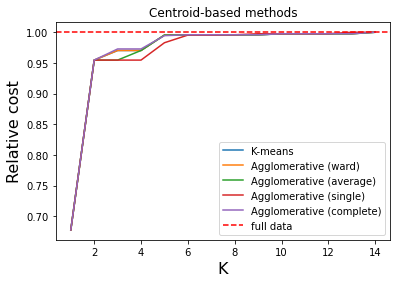

In [17]:
centroid_methods = ['K-means', 'Agglomerative (ward)', 'Agglomerative (average)',\
                    'Agglomerative (single)', 'Agglomerative (complete)']
for n_m, method in enumerate(centroid_methods):
    plt.plot(n_scenarios_range, reduced_models[n_m, :, -1] / true_cost, label=method)
plt.title("Centroid-based methods")
plt.ylabel("Relative cost", fontsize=16)
plt.xlabel("K", fontsize=16)
plt.axhline(1.0, color='r', ls='--', label='full data')
plt.legend()
plt.show()

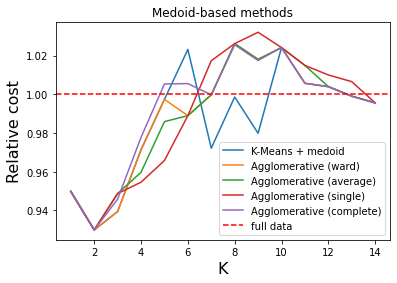

In [18]:
medoid_methods = ['K-Means + medoid', 'Agglomerative (ward)', 'Agglomerative (average)',\
                  'Agglomerative (single)', 'Agglomerative (complete)']
for n_m, method in enumerate(medoid_methods):
    n_m += len(centroid_methods)
    plt.plot(n_scenarios_range, reduced_models[n_m, :, -1] / true_cost, label=method)
plt.title("Medoid-based methods")
plt.ylabel("Relative cost", fontsize=16)
plt.xlabel("K", fontsize=16)
plt.axhline(1.0, color='r', ls='--', label='full data')
plt.legend()
plt.show()

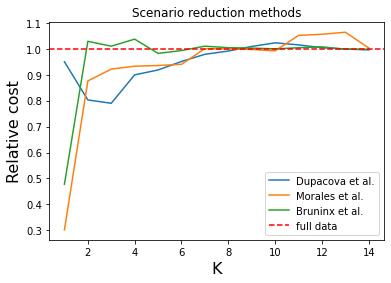

In [19]:
sr_methods = ['Dupacova et al.', 'Morales et al.', 'Bruninx et al.']
for n_m, method in enumerate(sr_methods):
    n_m = n_m + len(centroid_methods) + len(medoid_methods)
    plt.plot(n_scenarios_range, reduced_models[n_m, :, -1] / true_cost, label=method)
plt.title("Scenario reduction methods")
plt.ylabel("Relative cost", fontsize=16)
plt.xlabel("K", fontsize=16)
plt.axhline(1.0, color='r', ls='--', label='full data')
plt.legend()
plt.show()

In [20]:
methods = ['K-means', 'Agglomerative (ward) + centroid', 'Agglomerative (average) + centroid', 'Agglomerative (single) + centroid', 'Agglomerative (complete) + centroid',\
           'K-means + medoid', 'Agglomerative (ward) + medoid', 'Agglomerative (average) + medoid', 'Agglomerative (single) + medoid', 'Agglomerative (complete) + medoid',\
           'Dupacova et al.', 'Morales et al.', 'Bruninx et al.']
for i, method in enumerate(methods):
    print("{} : x = {:.2f}, obj = {:.2f}, x_gap = {:.2f} %, obj_gap = {:.2f} %"\
          .format(method, reduced_models[i, 4, 0], reduced_models[i, 4, -1],\
                  abs(true_x - reduced_models[i, 4, 0]) / true_x * 100,\
                  abs(true_cost - reduced_models[i, 4, -1]) / true_cost * 100))
print("All scenarios : x = {:.2f}, obj = {:.2f}".format(true_x, true_cost))

K-means : x = 84.28, obj = 695.90, x_gap = 7.69 %, obj_gap = 0.46 %
Agglomerative (ward) + centroid : x = 84.28, obj = 695.90, x_gap = 7.69 %, obj_gap = 0.46 %
Agglomerative (average) + centroid : x = 84.28, obj = 695.90, x_gap = 7.69 %, obj_gap = 0.46 %
Agglomerative (single) + centroid : x = 76.71, obj = 687.18, x_gap = 1.98 %, obj_gap = 1.71 %
Agglomerative (complete) + centroid : x = 71.16, obj = 695.24, x_gap = 9.08 %, obj_gap = 0.56 %
K-means + medoid : x = 86.39, obj = 697.27, x_gap = 10.39 %, obj_gap = 0.27 %
Agglomerative (ward) + medoid : x = 86.39, obj = 697.27, x_gap = 10.39 %, obj_gap = 0.27 %
Agglomerative (average) + medoid : x = 86.39, obj = 689.26, x_gap = 10.39 %, obj_gap = 1.41 %
Agglomerative (single) + medoid : x = 74.23, obj = 675.21, x_gap = 5.15 %, obj_gap = 3.42 %
Agglomerative (complete) + medoid : x = 73.96, obj = 702.85, x_gap = 5.49 %, obj_gap = 0.53 %
Dupacova et al. : x = 74.23, obj = 641.92, x_gap = 5.15 %, obj_gap = 8.18 %
Morales et al. : x = 81.73, ob

In [21]:
def plot_results(scenarios, labels, cluster_centers, cluster_weights, model_name):
    for label in np.unique(labels):
        label_id = np.where(labels == label)
        plt.scatter(scenarios[label_id, 0], scenarios[label_id, 1], s=100)
    
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=400 * cluster_weights,\
                marker=(5, 1), c='gold', label="Repr. scenario")
    plt.title(model_name)
    plt.xlabel("Demand [p.u.]")
    plt.ylabel("Wind capacity factor [%]")
    plt.legend()
    plt.show()

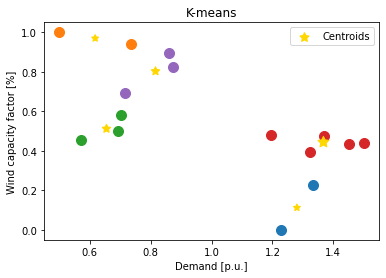

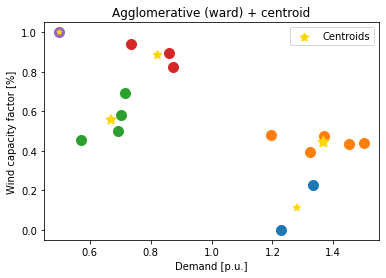

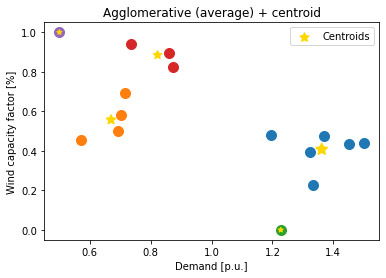

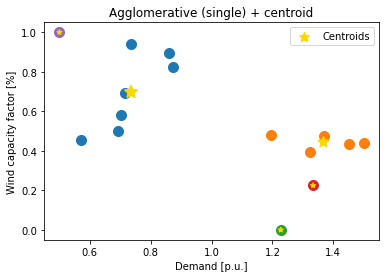

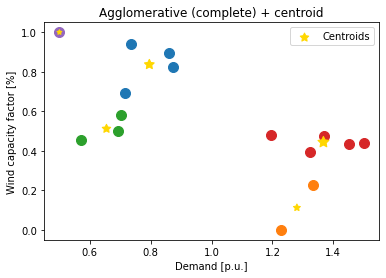

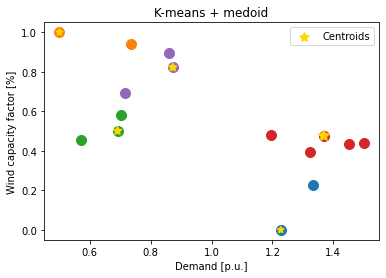

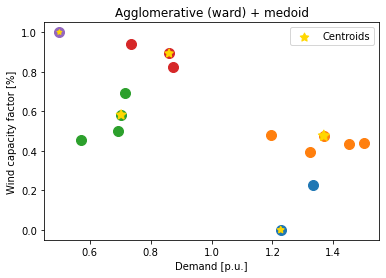

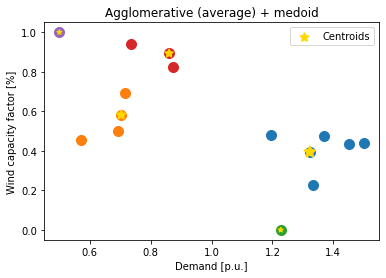

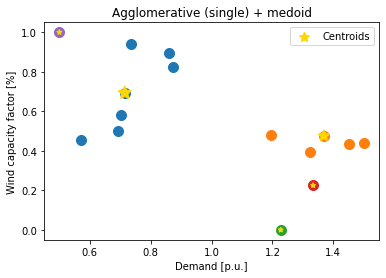

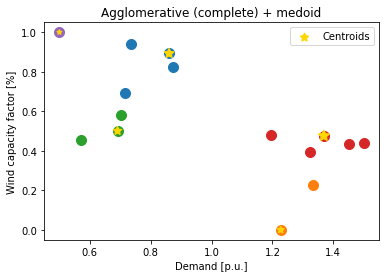

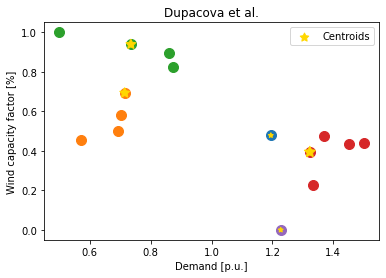

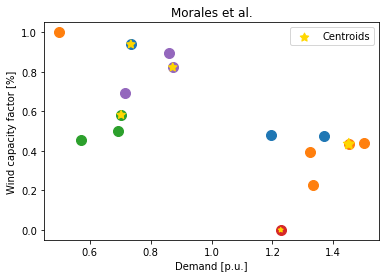

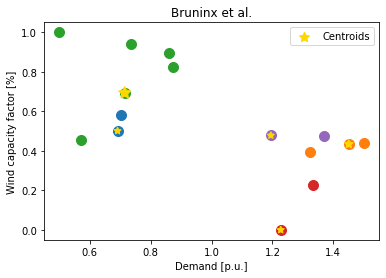

In [10]:
from src.reduction.clustering import cluster
from itertools import product

models = [KMeans, AgglomerativeClustering, ScenarioReduction]
parameters_dict = {
    'KMeans' : {
        'random_state' : [0]
    },
    'AgglomerativeClustering' : {
        'linkage' : ['ward', 'average', 'single', 'complete']
    },
    'ScenarioReduction' : {
        'method' : ['Dupacova', 'Morales', 'Bruninx']
    }
}
cluster_representations = ['centroid', 'medoid']
opt_problem = "Wind Investment"

n_m = 0
for cluster_representation in cluster_representations:
    for model in models:
        if model.__name__ != "ScenarioReduction":
            model_parameter_combinations = [ dict(zip(parameters_dict[model.__name__].keys(), v)) for v in product(*parameters_dict[model.__name__].values()) ]
            for model_parameters in model_parameter_combinations:
                w_r, rho, labels = cluster(scenarios, 5, model, model_parameters, cluster_representation)
                plot_results(scenarios, labels, w_r, rho, methods[n_m])
                n_m += 1

for model in models:
    if model.__name__ == "ScenarioReduction":
        for method in parameters_dict[model.__name__]['method']:
            m = ScenarioReduction(method, opt_problem, 5, problem_parameters)
            w_r, rho, labels = m.fit_return(scenarios)
            
            plot_results(scenarios, labels, w_r, rho, methods[n_m])
            n_m += 1